In [ ]:
   # Install Library
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import Library
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
import tensorflow as tf

# audio plot
from scipy.io import wavfile as wav
import IPython.display as ipd

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense,GlobalAveragePooling2D, Dropout
from sklearn.metrics import confusion_matrix, classification_report

# Load Data

In [ ]:
# Create Dataset Path
dataset_path = '/content/drive/MyDrive/Semester 4/Project/SR/cats_dogs/train'

In [ ]:
# Gathering Data
dataset = list(glob.glob(dataset_path + '/**/*.wav'))

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], dataset))
file_path = pd.Series(dataset, name = 'File_Path').astype(str)
labels = pd.Series(labels, name = 'Labels')
data = pd.concat([file_path, labels], axis = 1)
data = data.sample(frac = 1).reset_index(drop = True)
data.head()

,File_Path,Labels
0,/content/drive/MyDrive/Semester 4/Project/SR/c...,cat
1,/content/drive/MyDrive/Semester 4/Project/SR/c...,dog
2,/content/drive/MyDrive/Semester 4/Project/SR/c...,cat
3,/content/drive/MyDrive/Semester 4/Project/SR/c...,cat
4,/content/drive/MyDrive/Semester 4/Project/SR/c...,cat


# Explanatory Data Analysis (EDA) and Visualization

In [ ]:
# Show Data
data.head()

,File_Path,Labels
0,/content/drive/MyDrive/Semester 4/Project/SR/c...,cat
1,/content/drive/MyDrive/Semester 4/Project/SR/c...,dog
2,/content/drive/MyDrive/Semester 4/Project/SR/c...,cat
3,/content/drive/MyDrive/Semester 4/Project/SR/c...,cat
4,/content/drive/MyDrive/Semester 4/Project/SR/c...,cat


TOTAL SAMPLE OF EACH CLASS
cat    164
dog    113
Name: Labels, dtype: int64


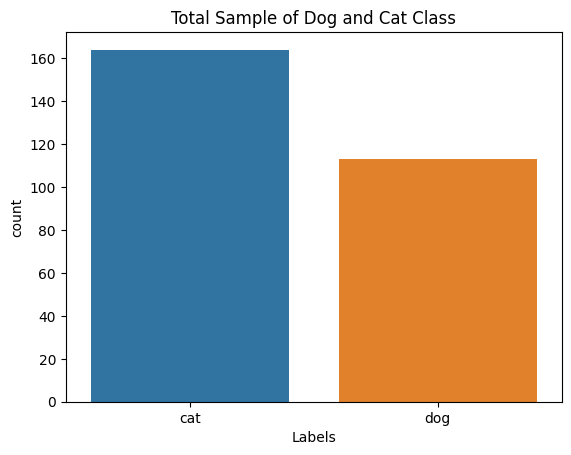

In [ ]:
# Show Total Sample of Each Class
print('TOTAL SAMPLE OF EACH CLASS')
print(data['Labels'].value_counts())
sns.countplot(x = 'Labels', data = data)
plt.title('Total Sample of Dog and Cat Class')
plt.show()

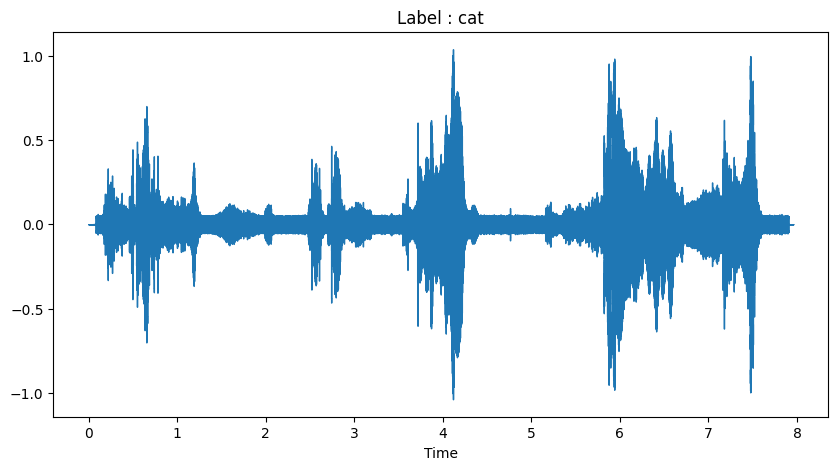

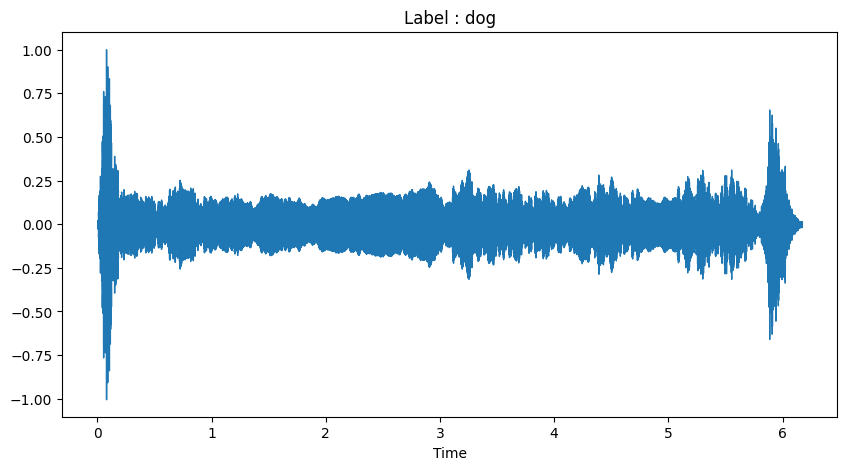

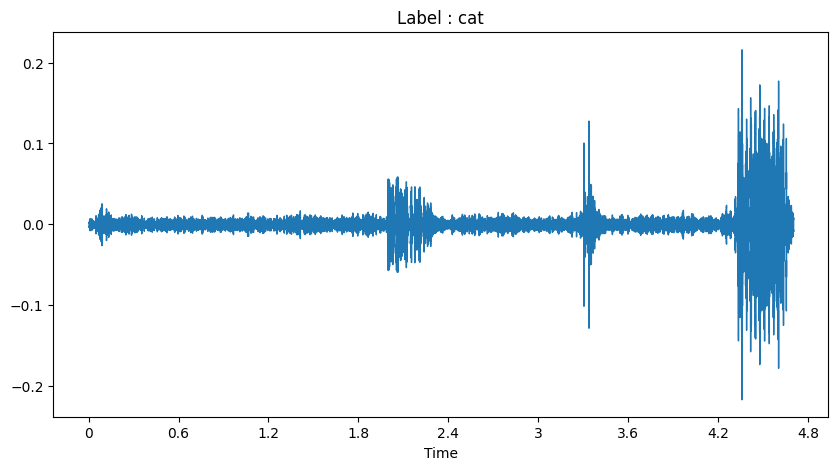

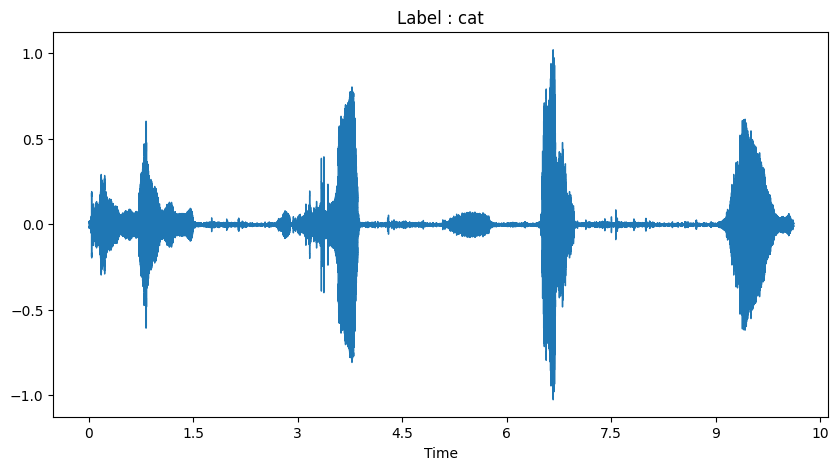

In [ ]:
# Show Waveform from Data
for i in range(4):
    x, sr = librosa.load(data.File_Path[i])
    plt.figure(figsize = (10, 5))
    plt.title('Label : ' + str(data['Labels'][i]))
    librosa.display.waveshow(x, sr = sr)

In [ ]:
# Display Audio
ipd.Audio(data.File_Path[1])

In [ ]:
# Display Audio
ipd.Audio(data.File_Path[4])

# Data Preprocessing

Feature Extraction - MFCC

In [ ]:
def feature_extract(file_name):
    audio, sr = librosa.load(file_name, res_type='soxr_vhq')
    mfccs = librosa.feature.mfcc(y = audio, sr = sr, n_mfcc = 40)
    mfccs_processed = np.mean(mfccs.T, axis = 0)
    return mfccs_processed

In [ ]:
features = []

for index, row in data.iterrows():
    file_name = str(row['File_Path'])
    class_label = row["Labels"]
    data_ = feature_extract(file_name)
    features.append([data_, class_label])

In [ ]:
features_df = pd.DataFrame(features, columns = ['Feature', 'Class_Label'])
features_df.head()

,Feature,Class_Label
0,"[-285.27402, 152.12965, -92.17864, 3.5563197, ...",cat
1,"[-323.16678, 170.78262, -31.627298, -37.475964...",dog
2,"[-441.96237, 145.26274, -2.6235387, 45.93477, ...",cat
3,"[-324.4479, 87.367546, -32.296204, 26.856525, ...",cat
4,"[-160.72746, 118.77562, -49.103832, 58.07156, ...",cat


Separate Variable

In [ ]:
x = np.array(features_df.Feature.tolist())
y = np.array(features_df.Class_Label.tolist())

Label Encoder

In [ ]:
label = LabelEncoder()
y = to_categorical(label.fit_transform(y))

Data Splitting

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)

# Modelling Using CNN

Build Model

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim = 40,  activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(46, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation = 'softmax'))

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2624      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 46)                2990      
                                                                 
 dropout_1 (Dropout)         (None, 46)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1504      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 6

Training Model

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'auto')

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    callbacks = [earlystop],
    epochs = 100
)

Epoch 1/100
7/7 [==============================] - 0s 13ms/step - loss: 0.2958 - accuracy: 0.8778 - val_loss: 0.2540 - val_accuracy: 0.9107
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.2967 - accuracy: 0.8778 - val_loss: 0.2511 - val_accuracy: 0.9107
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.3175 - accuracy: 0.8824 - val_loss: 0.2458 - val_accuracy: 0.9286
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.2787 - accuracy: 0.9005 - val_loss: 0.2423 - val_accuracy: 0.9286
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.2945 - accuracy: 0.8733 - val_loss: 0.2394 - val_accuracy: 0.9286
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 0.3598 - accuracy: 0.9005 - val_loss: 0.2363 - val_accuracy: 0.9107
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.2682 - accuracy: 0.8778 - val_loss: 0.2360 - val_accuracy: 0.9107
Epoch 8/100
7/7 [======

# Evaluation Model

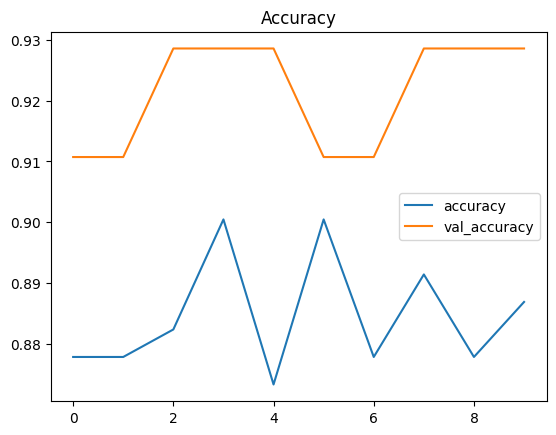

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

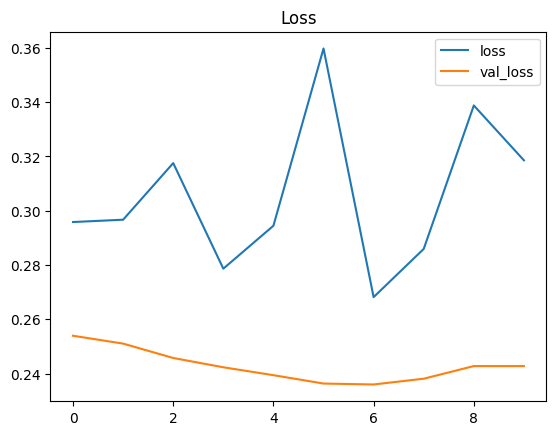

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
score = model.evaluate(x_train, y_train, verbose = 0)
print("Training Accuracy : \033[01m {0:.2%}\033[0m".format(score[1]))

score = model.evaluate(x_test, y_test, verbose = 0)
print("Testing Accuracy : \033[01m {0:.2%}\033[0m".format(score[1]))

Training Accuracy :  90.50%
Testing Accuracy :  92.86%


# Prediction

In [ ]:
def prediction(path_sound):
    data_sound = feature_extract(path_sound)
    X = np.array(data_sound)
    X = X.reshape(1, 40)
    pred_ = model.predict(X)
    pred_ = np.argmax(pred_, axis = 1)
    pred_class = label.inverse_transform(pred_)
    print("The predicted class : \033[01m ", pred_class[0],'\033[0m \n')

In [ ]:
path_sound = '/content/drive/MyDrive/Semester 4/Project/SR/cats_dogs/test/cat/cat_1.wav'
prediction(path_sound)
ipd.Audio(path_sound)

1/1 [==============================] - 0s 34ms/step
The predicted class :   cat  



In [ ]:
path_sound = '/content/drive/MyDrive/Semester 4/Project/SR/cats_dogs/test/dog/dog_barking_6.wav'
prediction(path_sound)
ipd.Audio(path_sound)

1/1 [==============================] - 0s 46ms/step
The predicted class :   dog  



In [ ]:
def conf_matrix(path_sound):
    data_sound = feature_extract(path_sound)
    X = np.array(data_sound)
    X = X.reshape(1, 40)
    pred_ = model.predict(X)
    pred_ = np.argmax(pred_, axis = 1)
    pred_class = label.inverse_transform(pred_)
    # print(confusion_matrix(y_test, pred_, labels = pred_class))
    return pred_class[0]

In [ ]:
y_true = []
y_pred = []

for index, row in data.iterrows():
    file_name = str(row['File_Path'])
    class_label = row["Labels"]
    data_ = conf_matrix(file_name)
    y_true.append(data_)
    y_pred.append(class_label)

1/1 [==============================] - 0s 51ms/step


In [ ]:
print(confusion_matrix(y_true, y_pred, labels = ['cat', 'dog']))
print(classification_report(y_true, y_pred, labels = ['cat', 'dog']))

[[162  23]
 [  2  90]]
              precision    recall  f1-score   support

         cat       0.99      0.88      0.93       185
         dog       0.80      0.98      0.88        92

    accuracy                           0.91       277
   macro avg       0.89      0.93      0.90       277
weighted avg       0.92      0.91      0.91       277

